# LIME on Tabular Data

### Lets Download Wine Dataaset and understand the lime

### Importing section

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#! pip install lime
import lime
from lime import lime_tabular
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from collections import OrderedDict
#!pip install opendatasets
import opendatasets as od
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import skimage
import skimage.transform
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.imagenet_utils import decode_predictions

### Downloading Wine dataest

Watch this video for understanding the process of downloading the dataset from kaggle https://www.youtube.com/watch?v=57N1g8k2Hwc

or 

read this blog : https://www.kaggle.com/discussions/general/51898


In [5]:
!pip install -q kaggle
from google.colab import files 
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
#! kaggle datasets list
! kaggle datasets download -d piyushagni5/white-wine-quality
!unzip -q white-wine-quality.zip -d .

Saving kaggle.json to kaggle.json
  0% 0.00/73.1k [00:00<?, ?B/s]
100% 73.1k/73.1k [00:00<00:00, 58.9MB/s]


### Loading the dataset

In [6]:
wine = pd.read_csv('winequality-white.csv',sep = ';')
wine.quality = wine.quality.apply(lambda x : 'good' if x > 5 else 'bad')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,good
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,good
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,good
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,good
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,good


Train Test Split

In [7]:
X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Letes train random forest classifier

In [8]:
model_tabular = RandomForestClassifier(random_state=42)
model_tabular.fit(X_train, y_train)
score = model_tabular.score(X_test, y_test)

### Model Interpretation

building explainer

In [9]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['bad', 'good'],
    mode='classification'
)

lets explain

In [10]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[20], 
    predict_fn=model_tabular.predict_proba
)

exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


# LIME on TEXT data

### Applying LIME to Quora dataset and Logistic regression model

if 403 forbidden "https://stackoverflow.com/questions/55761202/is-there-any-alternative-way-to-download-kaggle-competition-data-in-colab"

In [11]:
! kaggle competitions download -c quora-insincere-questions-classification
!unzip -q quora-insincere-questions-classification.zip -d .

100% 6.02G/6.03G [01:18<00:00, 108MB/s]
100% 6.03G/6.03G [01:18<00:00, 82.9MB/s]


load the dataset and vectorise the traindataset using tf-idf vectoriser

In [12]:
train_df = pd.read_csv(r"train.csv")
print("Train shape : ", train_df.shape)

## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)
val_df.reset_index(drop=True)

## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 100000, analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["question_text"])
val_vc = tfidf_vc.transform(val_df["question_text"])

Train shape :  (1306122, 3)


In [13]:
train_df.head()

,qid,question_text,target
651064,7f8590ef60e30b4344fd,What have been the best exhibits at the Museo ...,0
1294259,fda9538a2e0a5b2dfc3c,How can I rotate batch image files?,0
1205706,ec528b4e3abc3347cd21,Which is the best cable operator in Thane west...,0
460090,5a1a41ea2086f2264eab,"How do I expand, factor and simplify in algebra?",0
1277213,fa4f394af94b2b094e15,Do you judge people often?,0


building logistic regression model on quora text problem

In [14]:
model_text = LogisticRegression(C = 0.5, solver = "sag")
model_text = model_text.fit(train_vc, train_df.target)
val_pred = model_text.predict(val_vc)

from sklearn.metrics import f1_score
val_cv = f1_score(val_df.target, val_pred, average = "binary")
print(val_cv)

0.4768372544263886


apply LimeTextExplainer function to generate local explanations for predictions

In [15]:
idx = val_df.index[130609]

c = make_pipeline(tfidf_vc, model_text)
class_names = ["sincere", "insincere"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(val_df["question_text"][idx], c.predict_proba, num_features = 10)

print("Question: \n", val_df["question_text"][idx])
print("Probability (Insincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 1])
print("Probability (Sincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 0])
print("True Class is:", class_names[val_df["target"][idx]])

Question: 
 When will Quora stop so many utterly stupid questions being asked here, primarily by the unintelligent that insist on walking this earth?
Probability (Insincere) = 0.7458213181572705
Probability (Sincere) = 0.2541786818427295
True Class is: insincere


In [16]:
exp.as_list()

[('stupid', 0.369772505826078),
 ('earth', 0.11141819300983578),
 ('Quora', 0.10199647413550447),
 ('insist', 0.09396492959447161),
 ('questions', 0.07274539200423973),
 ('primarily', -0.07242276447527206),
 ('utterly', 0.03725789873407233),
 ('asked', -0.03642984973674197),
 ('unintelligent', 0.01826929399074902),
 ('walking', -0.002785009701081889)]

In [17]:
print('Original prediction:',  model_text.predict_proba(val_vc[130609])[0, 1])
tmp = val_vc[130609].copy()
tmp[0, tfidf_vc.vocabulary_['stupid']] = 0
tmp[0, tfidf_vc.vocabulary_['earth']] = 0
print('Prediction after removing some features:', model_text.predict_proba(tmp)[0, 1])
print('Difference:', model_text.predict_proba(tmp)[0, 1] - model_text.predict_proba(val_vc[130609])[0, 1])

Original prediction: 0.7458213181572705
Prediction after removing some features: 0.33714829087285586
Difference: -0.4086730272844146


In [18]:
exp.show_in_notebook(text=val_df["question_text"][idx], labels=(1,))

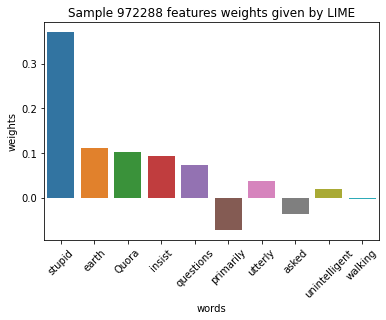

In [19]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(idx))
plt.show()

# LIME on IMAGE data

downloading cats vs dogs dataset from kaggle

In [24]:
od.download("https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda/download?datasetVersionNumber=1")

100%|██████████| 376M/376M [00:05<00:00, 66.6MB/s]


generate training data

In [26]:
dir_ = os.path.join('/content/animal-image-datasetdog-cat-and-panda/animals/animals')
train_datagen = ImageDataGenerator(rescale=1/255,validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(dir_,target_size=(100, 100),
                                                   batch_size= 1920,
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   subset = 'training')
test_generator = train_datagen.flow_from_directory(dir_,
                                                          target_size = (100,100),
                                                          batch_size = 480,
                                                          class_mode = 'categorical',
                                                          shuffle=False,
                                                          subset = 'validation')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [27]:
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)
test_filepath = []
for filepath in test_generator.filepaths:
    filepath = filepath.replace('\\', '/')
    test_filepath.append(filepath)

## Building custom cnn model

In [29]:
model_image = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    
    # Output neuron. 
        Dense(3, activation='softmax') 
])
model_image.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)      

Lets plot the model

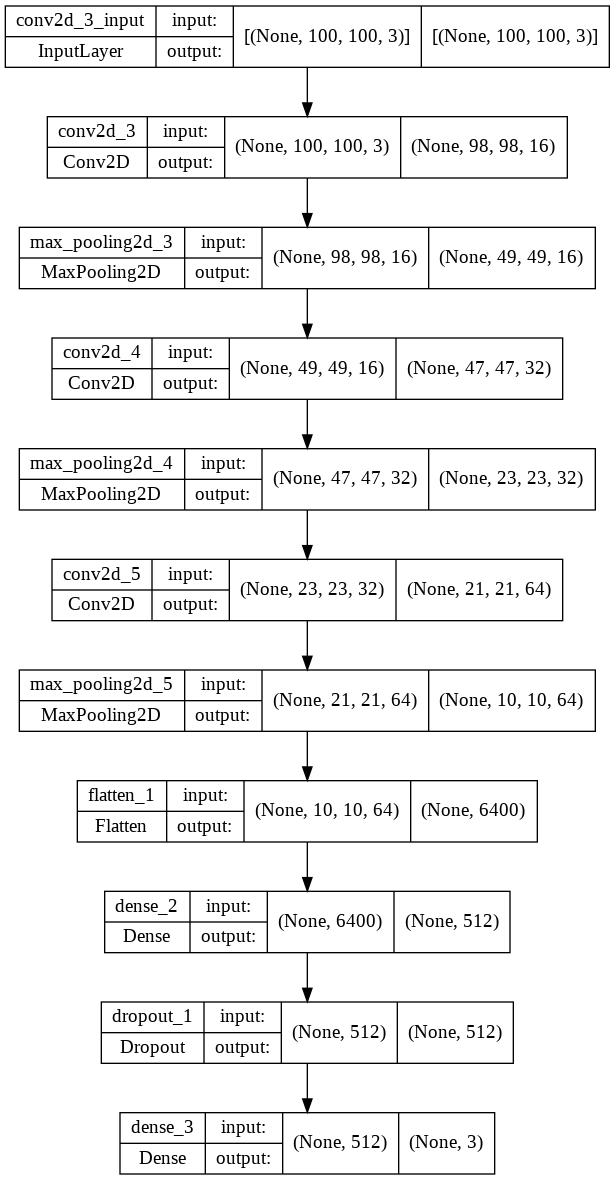

In [31]:
plot_model(model_image, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

lets compile and run the model

In [34]:
tf.keras.backend.clear_session()
model_image.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_image.fit(train_generator,epochs=80,validation_data=test_generator,verbose=1)

Epoch 1/80
2/2 [==============================] - 10s 4s/step - loss: 1.1529 - accuracy: 0.3333 - val_loss: 1.0442 - val_accuracy: 0.3333
Epoch 2/80
2/2 [==============================] - 9s 4s/step - loss: 1.0273 - accuracy: 0.3333 - val_loss: 1.0423 - val_accuracy: 0.3333
Epoch 3/80
2/2 [==============================] - 9s 4s/step - loss: 1.0204 - accuracy: 0.3333 - val_loss: 1.1547 - val_accuracy: 0.3333
Epoch 4/80
2/2 [==============================] - 9s 7s/step - loss: 1.5423 - accuracy: 0.3333 - val_loss: 1.3718 - val_accuracy: 0.3333
Epoch 5/80
2/2 [==============================] - 9s 4s/step - loss: 1.3834 - accuracy: 0.3333 - val_loss: 1.0749 - val_accuracy: 0.3333
Epoch 6/80
2/2 [==============================] - 9s 7s/step - loss: 1.0371 - accuracy: 0.3333 - val_loss: 1.0281 - val_accuracy: 0.3333
Epoch 7/80
2/2 [==============================] - 9s 4s/step - loss: 1.0327 - accuracy: 0.3333 - val_loss: 1.0049 - val_accuracy: 0.3333
Epoch 8/80
2/2 [========================

In [35]:
model_image.save('lime_default')
model_image = tf.keras.models.load_model('lime_default')

## Lets Predict an Image with Custom Model

It's a dog!
0.83618075


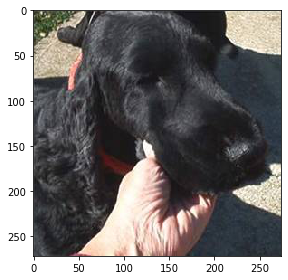

In [92]:
url = "/content/animal-image-datasetdog-cat-and-panda/animals/dogs/dogs_00073.jpg"

def read_and_transform_img(url):
    img = skimage.io.imread(url)
    skimage.io.imshow(img)
    img = skimage.transform.resize(img, (100,100,3))  
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

images = read_and_transform_img(url)

preds = model_image.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
elif prediction == 1:
    print('It\'s a dog!')
else:
    print('It\'s a panda!')
print(pct)

In [93]:
preds

array([[0.09892601, 0.83618075, 0.06489321]], dtype=float32)

In [94]:
explainer = lime_image.LimeImageExplainer()

## LIME with Custom Model

In [95]:
explanation = explainer.explain_instance(images[0].astype('double'), model_image.predict,top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

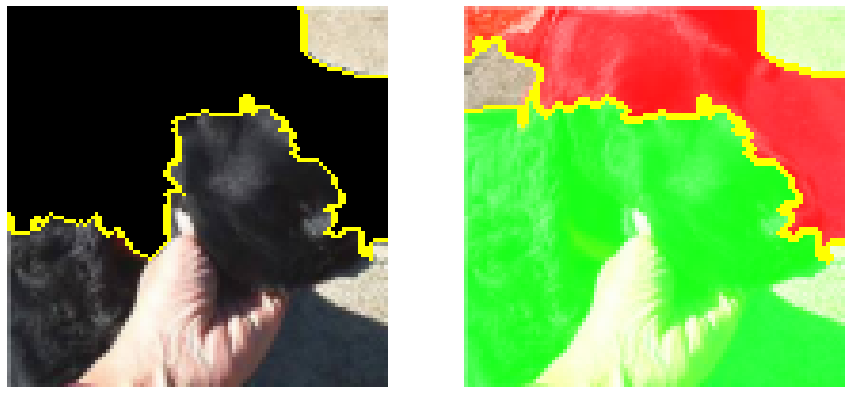

In [96]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')

## LIME with Inception V3

In [97]:
inet_model = inc_net.InceptionV3()

In [98]:
def transform_img_fn_ori(url):
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

In [99]:
images_inc_im = transform_img_fn_ori(url)

('n02102318', 'cocker_spaniel', 0.24879697)
('n02099267', 'flat-coated_retriever', 0.098157525)
('n02099429', 'curly-coated_retriever', 0.05417455)
('n02099712', 'Labrador_retriever', 0.037757803)
('n02097130', 'giant_schnauzer', 0.03206823)


In [100]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), inet_model.predict,  top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

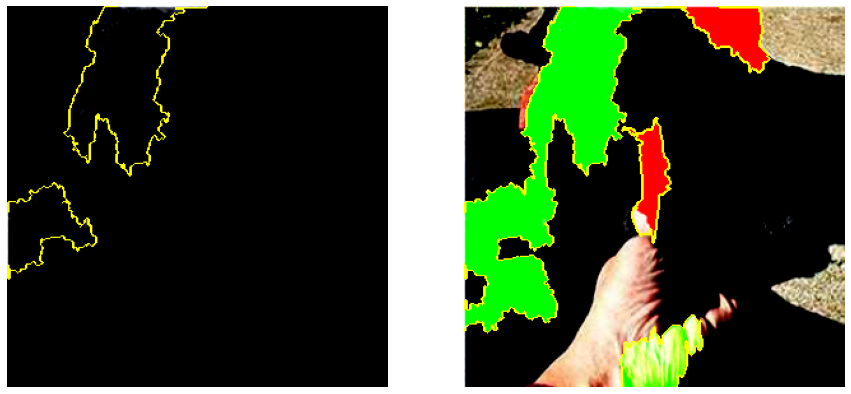

In [101]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_inception.png')
